# Efeito Rossiter McLaughlin

* PET - Física
* Petiano: Bruno Ramos Galindo
* Data: 23/11/2024

$\quad$ Neste `Notebook`, o objetivo principal é entender o efeito Rossiter-McLaughlin e aplicar esse efeito em códigos que permitam determinar a velocidade radial e a inclinação entre o plano orbital de um exoplaneta e o equador da sua estrela hospedeira.

$\quad$ O efeito Rossiter-McLaughlin é um fenômeno observado durante o trânsito de um exoplaneta, em que a velocidade radial medida pela estrela é distorcida devido à interação entre a estrela e o exoplaneta. Esse efeito pode fornecer informações valiosas sobre a geometria da órbita do exoplaneta, incluindo a inclinação orbital e a velocidade de rotação da estrela.

$\quad$ Nosso objetivo aqui será simular o efeito Rossiter-McLaughlin (RM) e implementar métodos para estimar os parâmetros que caracterizam a órbita do exoplaneta e sua relação com a estrela hospedeira. Para isso, vamos focar em dois aspectos principais:

- Simulação do efeito Rossiter-McLaughlin (RM)
- Análise dos dados reais da estrela HAT-P-2

O presente `Notebook` será terá as seguintes Seções:

 1. Uma breve introdução
 2. Simulação Montecarlo com correntes Markov
 3. Implementando os códigos
 4. Conclusão
 5. Referências

$\quad$ Para que o `Notebook`, seja aplicado pelo leitor, é preciso ter um ambiente Python com as seguintes bibliotecas: `numpy`,`matplotlib`, `rmfit`,`batman`, `corner` e `astroquery`. Para melhor funcionamento do código, recomendo que o leitor aplique o código no `Google Colab`, pois em outras plataformas algumas bibliotecas podem não funcionar de maneira adequada.  

## Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import corner
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astroquery.vizier import Vizier
import batman
import rmfit

C:\Users\tiago\anaconda3\lib\site-packages\pytools\persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


## Versão das bibliotecas

In [2]:
%load_ext version_information
%version_information matplotlib, batman, rmfit, astroquery, corner, numpy, pandas

Software versions
Python 3.9.19 64bit [MSC v.1929 64 bit (AMD64)]
IPython 8.18.1
OS Windows 10 10.0.19045 SP0
matplotlib 3.9.1
batman 2.4.8
rmfit 1.0.2
astroquery 0.4.7
corner 2.2.2
numpy 1.24.3
pandas 2.2.2
Fri Nov 22 21:27:44 2024 Hora Padrão de Buenos Aires

## 1 - Uma breve introdução

$\quad$  O trânsito planetário foi observado pela primeira vez no ano de 1639, por Jeremiah Horrocks. Ele observou o planeta Vênus passando pelo disco estelar do Sol. Embora, no ano de 1611, Christoph Scheiner, observou um sistema de planetas próximos ao Sol, que interpretou erroneamente, pensando que se tratava de manchas solares no Sol. Scheiner observou as "Manchas Solares" por anos e descobriu que o equador do Sol está inclinado em um ângulo de 7° em relação ao plano orbital da Terra.

$\quad$ Atualmente, sabemos da existência de várias estrelas que possuem um exoplaneta as orbitando. Nestes exoplanetas, pode ocorrer um desalinhamento entre o plano orbital do exoplaneta e o equador da estrela, para essa inclinação damos o nome de obliquidade estelar.

$\quad$ O método utilizado por Christoph Scheiner não pode ser usado para exoplanetas e não podemos observar o exoplaneta passar pelo disco estelar com nossos telescópios. Em vez disso, podemos obter a obliquidade estelar usando um fenômeno chamado de efeito Rossiter McLaughlin (RM). O efeito é observado no trânsito planetário, ele consiste na absorção das linhas de velocidade radial no espectro eletromagnético pelo exoplaneta, quando parte da rotação da estrela é escondida pelo exoplaneta. Quando a estrela realiza o movimento de rotação, uma parte se "aproxima" de nós e outra parte se "afasta" de nós. A parte se aproximando terá um **Blue Shift**(desvio para o azul) e a parte se afastando terá um **Red Shift**(desvio para o vermelho).

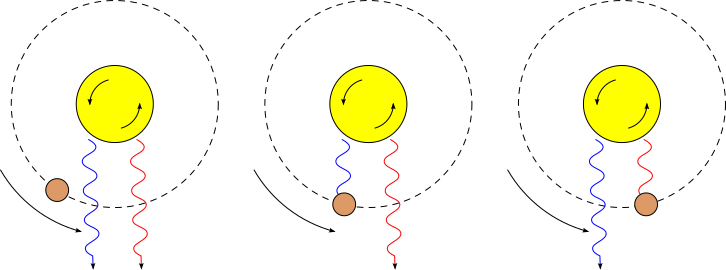

$\quad$À medida que o planeta passa em frente à estrela, ele bloqueia sequencialmente a luz deslocada para o azul e para o vermelho, fazendo com que a velocidade radial aparente da estrela mude, mas, na verdade, não muda.

$\quad$ Da mesma forma, quando a metade da estrela com desvio para o vermelho (recuo) está bloqueada, o espectro é desviado para o azul. O resultado é um “deslocamento Doppler anômalo” que varia ao longo do eclipse. Monitorando as linhas estelares feitas por eclipses, podemos medir a obliquidade estelar. Tal fenômeno foi previsto por Holt em 1893, mas observado somente em 1924 por Rossiter e McLaughlin.

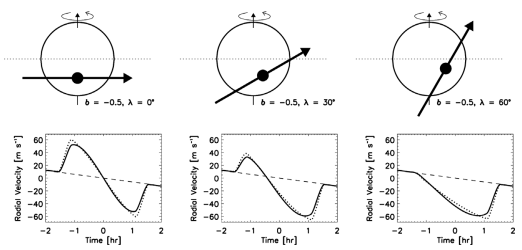

$\quad$ Na figura acima, temos três trânsitos planetários que produzem curvas de luz geometricamente idênticas, apesar de diferirem no alinhamento orbital em relação ao eixo de rotação da estrela; em baixo, temos as respectivas velocidades radiais. À esquerda: um alinhamento aproximado entre o plano orbital da estrela e o eixo de rotação da estrela, produzindo um efeito de doppler simétrico; no centro, uma inclinação de 30° produz um sinal assimétrico; e à direita, uma inclinação de 60° produz apenas blueshift. Crédito: Gaudi & Winn (2007).

$\quad$ Para determinar a variação de velocidade radial, podemos utilizar a equação dada por:

$$\Delta V_{rad} \sim \left(\frac{R_p}{R_*}\right)\sqrt{1-b^2}(v_*sini_*)\text{.} \tag{1.1}$$

$\quad$ Sendo $R_p$ o raio do exoplaneta; $R_*$ o raio da estrela; $b$ é o parametro de impacto; $v_*sini_*$ é a velocidade rotacional da estrela. O parâmetro de impacto é o valor que determina onde o exoplaneta está em relação ao equador da estrela.



## 2 - Simulação de Monte Carlo com correntes Markov

$\quad$ Nesta Seção, vamos explorar o funcionamento do Markov Chain Monte Carlo (MCMC), uma técnica que será utilizada posteriormente no código. Essa abordagem é fundamental para resolver problemas complexos de amostragem e estimação em estatística e ciência de dados.

$\quad$ MCMC (Markov Chain Monte Carlo) é uma ampla classe de ferramentas computacionais utilizadas para aproximar integrais e gerar amostras de uma distribuição de probabilidade posterior (S. Brooks, Gelman, Jones, & Meng, 2011). Essa técnica é empregada quando não é possível obter amostras diretamente da distribuição posterior 𝑃(𝜃|dados). Em vez disso, as amostras são geradas de forma iterativa, de modo que, a cada passo do processo, a distribuição simulada $P^*(θ^*∣dados)$ (onde o asterisco indica uma amostra simulada) se aproxima cada vez mais da verdadeira distribuição posterior 𝑃(𝜃∣dados). O objetivo é evitar o cálculo direto do denominador 𝑃(dados), que frequentemente é inviável.

$\quad$ A ideia central é construir uma cadeia de Markov ergódica, ou seja, uma cadeia que possui uma única distribuição estacionária. Nesse contexto, o conjunto de estados possíveis corresponde ao espaço amostral, e a distribuição estacionária é justamente a distribuição que desejamos aproximar ou da qual queremos obter amostras.

$\quad$ Considere uma simulação da cadeia representada por **$X_0,X_1,...,X_n$**. Após um número suficientemente grande de iterações
$𝑟$, a cadeia converge para a distribuição estacionária independentemente do estado inicial $𝑋_0$. Nesse ponto, a distribuição do estado
$𝑋_r$estará próxima da distribuição estacionária, permitindo que o utilizemos como uma amostra.

$$P(X_{n+1} = x| X_0,X_1,X_2,...,X_n) = P(X_{n+1} = x | X_n)\text{.} \tag{2.1}$$

$\quad$ Essa propriedade, chamada de Markoviana, homenageia o matemático Andrei Andreyevich Markov.

$\quad$ Por uma repetição do mesmo argumento, usando $X_r$ como o novo ponto inicial, podemos considerar $X_{2r}$ como outra amostra, e assim por diante. Isso nos permite gerar a sequência $X_r, X_{2r}, X_{3r},...,$ que pode ser tratada como quase amostras independentes da distribuição estacionária da cadeia de Markov.

$\quad$ Adicionalmente, é comum descartar as primeiras iterações do algoritmo MCMC, pois essas geralmente não são representativas da distribuição alvo. Durante essas iterações iniciais, a cadeia de Markov passa por um período de aquecimento (warm-up), no qual o estado da cadeia pode estar consideravelmente distante da distribuição estacionária desejada.

$\quad$ Para garantir uma amostragem mais confiável, é recomendável eliminar essa fase inicial. De acordo com Gelman et al. (2013a), uma prática usual é descartar aproximadamente metade das iterações realizadas. Por exemplo, se a cadeia de Markov tem um total de 4.000 iterações, as 2.000 primeiras seriam descartadas como parte do processo de warm-up. Isso ajuda a assegurar que as amostras utilizadas sejam mais próximas da distribuição estacionária e, consequentemente, mais representativas.

# 3 - Implementando os códigos

$\quad$ Aplicando condições para a plotagem do gráfico:

In [3]:
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

## 3.1 - Simulando o efeito RM

$\quad$ Nessa Subseção usaremos um código simples para observar como os parametros da Equação **(1.1)** alteram a velocidade radial.

$\quad$ A seguir usamos a Equação **(1.1)** e definimos uma série de parâmetros físicos essenciais para a modelagem de sistemas estelares e planetários. Inicialmente, definimos os valores do raio da estrela (R_s) e do planeta (R_p) em unidades solares, além da velocidade de rotação da estrela (v_rot) em km/s. A inclinação orbital (i_orbit) é fixada em 90 graus, o que implica um trânsito frontal, e o parâmetro de impacto (b) é configurado como 0.5, representando a distância mínima entre o centro da estrela e a trajetória do planeta, em unidades do raio da estrela.

In [4]:
# Parâmetros físicos
R_s = 1.146         # Raio da estrela em unidades solares
R_p = 0.00138       # Raio do planeta em unidades solares
v_rot = -3.75       # Velocidade de rotação da estrela em km/s
i_orbit = 90        # Inclinação orbital em graus (assumimos trânsito frontal)
b = 0.5             # Impact parameter (distância mínima do centro da estrela em unidades de R_s)
# Parâmetros físicos
R_s2 = 1.146
R_p2 = 0.00138
v_rot2 = -5
i_orbit = 90
b2 = 0.5
# Parâmetros físicos
R_s2 = 1.146
R_p2 = 0.00138
v_rot3 = -2.75
i_orbit = 90
b2 = 0.5

os parâmetros são repetidos para diferentes configurações (R_s2, R_p2, v_rot2, entre outros), com pequenas variações na velocidade de rotação da estrela (v_rot2 e v_rot3), mantendo os outros parâmetros constantes. O bloco de código abaixo define os parâmetros para simular o trânsito de um planeta em frente à sua estrela, considerando diferentes cenários.



In [5]:
# Parâmetros do trânsito
t_total = 0.5      # Duração total do trânsito em horas
n_points = 100     # Número de pontos para simulação
tempo = np.linspace(-t_total/2, t_total/2, n_points)

# Cálculo da posição do planeta durante o trânsito
x_planet = np.linspace(-np.sqrt((R_s + R_p)**2 - b**2), np.sqrt((R_s + R_p)**2 - b**2), n_points)
y_planet = np.full_like(x_planet, b)

x_planet2 = np.linspace(-np.sqrt((R_s2 + R_p2)**2 - b2**2), np.sqrt((R_s2 + R_p2)**2 - b2**2), n_points)
y_planet2 = np.full_like(x_planet2, b2)

x_planet3 = np.linspace(-np.sqrt((R_s2 + R_p2)**2 - b2**2), np.sqrt((R_s2 + R_p2)**2 - b2**2), n_points)
y_planet3 = np.full_like(x_planet2, b2)

$\quad$ No bloco a seguir, temos a função `efeito_rossiter_mcLaughlin` que calcula o efeito Rossiter-McLaughlin, que descreve a variação na velocidade radial observada durante um trânsito planetário, devido ao movimento do planeta sobre a superfície estelar.

In [6]:
# Função para calcular o efeito Rossiter-McLaughlin
def efeito_rossiter_mcLaughlin(x, y, R_s, R_p, v_rot):
    # Verificar a posição do planeta dentro do disco estelar
    r = np.sqrt(x**2 + y**2)
    dentro_estelar = r < R_s

    # Velocidade radial devido à rotação estelar
    v_proj = np.where(dentro_estelar, v_rot * (x / R_s), 0)

    # Bloquear a velocidade radial nas posições onde o planeta cobre a estrela
    bloqueado = r < R_p
    v_proj[bloqueado] = 0

    # Retornar a velocidade radial observável (média sobre o disco visível)
    return np.mean(v_proj)

$\quad$ Esse trecho de código aplica a função `efeito_rossiter_mcLaughlin` para calcular as variações na velocidade radial ($\Delta V$) ao longo do trânsito planetário em três cenários diferentes.

In [7]:
# Aplicar a função para cada posição do planeta durante o trânsito
delta_Vs = np.array([efeito_rossiter_mcLaughlin(x, y_planet[i], R_s, R_p, v_rot) for i, x in enumerate(x_planet)])

delta_Vs2 = np.array([efeito_rossiter_mcLaughlin(x, y_planet2[i], R_s2, R_p2, v_rot2) for i, x in enumerate(x_planet)])

delta_Vs3 = np.array([efeito_rossiter_mcLaughlin(x, y_planet3[i], R_s2, R_p2, v_rot3) for i, x in enumerate(x_planet)])

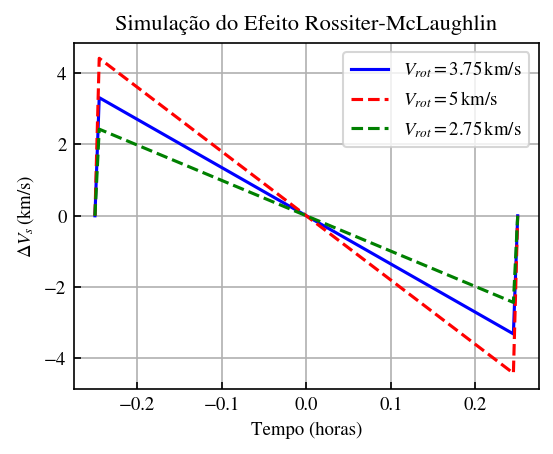

In [8]:
# Visualizar o efeito Rossiter-McLaughlin
fig, ax2 = plt.subplots(figsize=(4, 3), dpi=150)
ax2.plot(tempo, delta_Vs, color='blue', label="$V_{rot}=3.75\\,\\mathrm{km/s}$")
ax2.plot(tempo, delta_Vs2, color='red', linestyle='--', label='$V_{rot}=5\\,\\mathrm{km/s}$')
ax2.plot(tempo, delta_Vs3, color='green', linestyle='--', label='$V_{rot}=2.75\\,\\mathrm{km/s}$')
ax2.grid(True)
ax2.set_xlabel("Tempo (horas)")
ax2.set_ylabel("$\Delta V_s\\,\\mathrm{(km/s)}$")
ax2.set_title("Simulação do Efeito Rossiter-McLaughlin")
ax2.legend()  # Chamada correta para exibir a legenda
plt.show()

$\quad$ Deste modo, no gráfico acima, podemos observar como o efeito Rossiter-McLaughlin (RM) afeta a medição da velocidade radial da estrela durante o trânsito do exoplaneta. O gráfico ilustra como a velocidade radial medida pela estrela varia dependendo da velocidade de rotação da estrela.



$\quad$Conforme a velocidade de rotação da estrela aumenta, o impacto do efeito RM se torna mais evidente, fazendo com que as distorções na medição da velocidade radial também aumentem. Isso ocorre porque o movimento do exoplaneta, combinado com a rotação da estrela, altera a velocidade radial observada durante o trânsito, criando variações no padrão esperado da velocidade radial.

## 3.2 - Utilizando dados da estrela HAT-P-2

$\quad$ Os dados que usaremos a seguir são obtidos diretamente da internet, ou seja, não há necessidade de baixar. Os dados podem ser encontrados na referência **[8]** basta [clicar aqui](https://ui.adsabs.harvard.edu/abs/2012ApJ...757...18A/abstract), em seguida na parte de DATA PRODUCTS clique em CDS onde o leitor será redirecionado para o site Vizier e terá acesso ao catálogo `J/ApJ/757/18`.

Abaixo buscaremos os dados do Vizier para a aplicação do código

In [9]:
# Configurar VizieR para buscar todos os resultados
v = Vizier(columns=["Name", "BJD", "RVel", "f_RVel", "e_RVel", "Inst"], row_limit=-1)

# Fazer a consulta pelo catálogo específico
result = v.query_constraints(catalog="J/ApJ/757/18")

# Verificar as tabelas disponíveis
print(result)

# Acessar a tabela específica
if "J/ApJ/757/18/table2" in result.keys():
    table2 = result["J/ApJ/757/18/table2"]
    df = table2.to_pandas()  # Converter para DataFrame
    hat_p2_data = df[df['Name'] == 'HAT-P-2']
else:
    print("Tabela J/ApJ/757/18/table2 não encontrada.")

TableList with 2 tables:
	'0:J/ApJ/757/18/table1' with 1 column(s) and 16 row(s) 
	'1:J/ApJ/757/18/table2' with 6 column(s) and 718 row(s) 


In [10]:
hat_p2_data = df[df['Name'] == 'HAT-P-2']
hat_p2_data

Name           BJD    RVel f_RVel  e_RVel   Inst
536  HAT-P-2  2.454258e+06  107.29          11.47  HIRES
537  HAT-P-2  2.454258e+06  113.38          11.27  HIRES
538  HAT-P-2  2.454258e+06  102.73          11.29  HIRES
539  HAT-P-2  2.454258e+06   73.36          11.12  HIRES
540  HAT-P-2  2.454258e+06   72.43          10.98  HIRES
..       ...           ...     ...    ...     ...    ...
628  HAT-P-2  2.454258e+06 -278.41          10.80  HIRES
629  HAT-P-2  2.454258e+06 -297.41          10.85  HIRES
630  HAT-P-2  2.454258e+06 -350.56          11.02  HIRES
631  HAT-P-2  2.454258e+06 -352.35          11.08  HIRES
632  HAT-P-2  2.454258e+06 -361.36          10.89  HIRES

[97 rows x 6 columns]

$\quad$ Gráfico da Velocidade Radial (RV) em função do Tempo (BJD) para o exoplaneta HAT-P-2b. As medições de RV são mostradas como pontos pretos, com barras de erro representando as incertezas associadas a cada observação. O tempo é dado em dias julianos baricêntricos (BJD), e a velocidade radial é expressa em metros por segundo (m/s). Este gráfico ilustra as variações da RV da estrela devido à interação com o planeta durante o trânsito, com base nas observações realizadas ao longo do tempo.

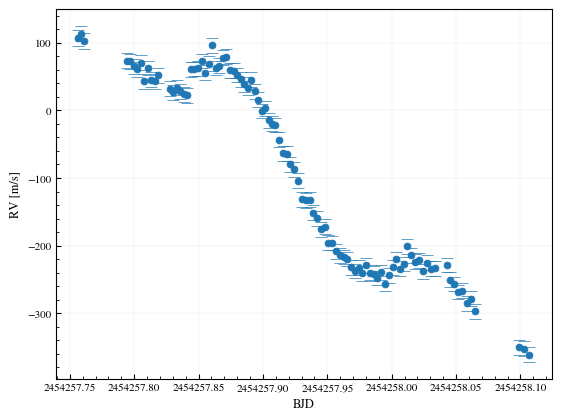

In [11]:
fig, ax = plt.subplots(dpi = 100)
ax.errorbar(hat_p2_data.BJD.values,hat_p2_data.RVel,hat_p2_data.e_RVel,marker='o',lw=0,mew=0.5,capsize=4)
rmfit.utils.ax_apply_settings(ax,ticksize=8)
ax.set_xlabel('BJD')
ax.set_ylabel('RV [m/s]');

$\quad$ A seguir faremos uma estrutura para armazenar alguns parâmetros. Esses parâmetros representam os valores iniciais e os limites para o ajuste de um modelo que descreve o comportamento dinâmico de um sistema exoplanetário, incluindo o trânsito do exoplaneta e os efeitos dinâmicos na estrela hospedeira.

In [12]:
parameters = {
    "t0_p1": {"type": "Normal", "value": [2454212.8561, 0.0006]}, #Tempo de trânsito
    "P_p1": {"type": "Normal", "value": [5.63341, 0.00013]},      #Período orbital
    "lam_p1": {"type": "Uniform", "value": [-180., 180.]},        #Ângulo de obliquidade
    "vsini": {"type": "Uniform", "value": [0.0, 30.]},            #Velocidade de rotação da estrela
    "inc_p1": {"type": "Uniform", "value": [85.0, 90.0]},         #Inclinação orbital
    "p_p1": {"type": "Normal", "value": [0.07227, 0.0007]},       #Razão de raios
    "a_p1": {"type": "Normal", "value": [9.0, 3.0]},              #Semi-eixo maior em unidades estelares
    "u1": {"type": "Normal", "value": [0.3, 0.05]},               #Coeficiente de escurecimento de bordo
    "u2": {"type": "Normal", "value": [0.3, 0.05]},               #Coeficiente de escurecimento de bordo
    "ecc_p1": {"type": "Normal", "value": [0.501, 0.007]},        #Excentricidade orbital
    "omega_p1": {"type": "Normal", "value": [-172.6, 1.6]},       #Ângulo de periastron
    "vbeta": {"type": "Normal", "value": [5.2, 0.5]},             #Velocidade de impacto estelar
    "K_p1": {"type": "Normal", "value": [1011., 38.]},            #Semi-amplitude da velocidade radial
    "gamma": {"type": "Uniform", "value": [-400., 400.]},         #Offset da velocidade radial
    "sigma_rv": {"type": "FIXED", "value": 0.0},                  #Incerteza instrumental
    "exptime": {"type": "FIXED", "value": 300.0},                 #Tempo de exposição

    "gammadot": {"type": "FIXED", "value": 0.0},                  #Parâmetros fixos relacionados à variação
    "gammadotdot": {"type": "FIXED", "value": 0.0},               #da velocidade radial com o tempo
    "vcb": {"type": "FIXED", "value": 0.0}                        #(e.g., aceleração) e à contribuiçãodo
}                                                                 #movimento do centro de massa do sistema.

$\quad$ No bloco de código a seguir, estamos criando um código que cria um arquivo para armazenar os valores da variável parâmetro.

In [13]:
with open("hatp2_priors2.dat", "w") as f:
    for key, param in parameters.items():
        if param["type"] == "Normal" or param["type"] == "Uniform":
            values = ",".join(map(str, param["value"]))
            f.write(f"{key}\t{param['type']}\t{values}\n")
        elif param["type"] == "FIXED":
            f.write(f"{key}\t{param['type']}\t{param['value']}\n")


$\quad$ Após a criação do arquivo, certifique-se de que o código e o arquivo gerado estejam salvos na mesma pasta. Abaixo carregamos um arquivo de priors (informações prévias sobre os
parâmetros) chamado `hatp2_priors2.dat` e utilizamos esses dados, com as medições de tempo (`hat_p2_data.BJD.values`), velocidade radial (`hat_p2_data.RVel`) e incertezas nas medições (`hat_p2_data.e_RVel`), para configurar uma função de probabilidade (`LPFunction`). Essa função é então passada para o objeto RMFit, responsável por ajustar o modelo aos dados observacionais, levando em conta as priors definidas no arquivo e as incertezas associadas às medições. Esse processo prepara a análise e o ajuste do modelo de velocidade radial.

In [14]:
data = 'hatp2_priors2.dat'
dados = rmfit.rmfit.LPFunction(hat_p2_data.BJD.values,hat_p2_data.RVel,hat_p2_data.e_RVel,data)
tabela = rmfit.rmfit.RMFit(dados)

Reading in priorfile from hatp2_priors2.dat
   prior          arg1       arg2        label  description priortype  fixed
0     NP  2.454213e+06    0.00060        t0_p1        t0_p1     model  False
1     NP  5.633410e+00    0.00013         P_p1         P_p1     model  False
2     UP -1.800000e+02  180.00000       lam_p1       lam_p1     model  False
3     UP  0.000000e+00   30.00000        vsini        vsini     model  False
4     UP  8.500000e+01   90.00000       inc_p1       inc_p1     model  False
5     NP  7.227000e-02    0.00070         p_p1         p_p1     model  False
6     NP  9.000000e+00    3.00000         a_p1         a_p1     model  False
7     NP  3.000000e-01    0.05000           u1           u1     model  False
8     NP  3.000000e-01    0.05000           u2           u2     model  False
9     NP  5.010000e-01    0.00700       ecc_p1       ecc_p1     model  False
10    NP -1.726000e+02    1.60000     omega_p1     omega_p1     model  False
11    NP  5.200000e+00    0.5000

$\quad$ O comando `tabela.minimize_PyDE(mcmc=False)` realiza uma minimização da função de probabilidade utilizando o método PyDE (uma técnica de otimização), sem recorrer ao MCMC. Ou seja, ele encontra o melhor ajuste para os parâmetros do modelo de forma determinística, tentando minimizar a diferença entre o modelo e os dados observacionais, usando uma abordagem mais direta, sem amostragem estocástica.

In [15]:
tabela.minimize_PyDE(mcmc=False)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv  center_dist
0      t0_p1  2.454213e+06  2.454213e+06  2.454213e+06  2.454213e+06    -0.000017
1       P_p1  5.633410e+00  5.632760e+00  5.634060e+00  5.633463e+00    -0.000053
2     lam_p1  0.000000e+00 -1.800000e+02  1.800000e+02  5.985798e+00    -5.985798
3      vsini  1.500000e+01  0.000000e+00  3.000000e+01  1.686952e+01    -1.869515
4     inc_p1  8.750000e+01  8.500000e+01  9.000000e+01  8.804127e+01    -0.541267
5       p_p1  7.227000e-02  6.877000e-02  7.577000e-02  7.279449e-02    -0.000524
6       a_p1  9.000000e+00 -6.000000e+00  2.400000e+01  1.023892e+01    -1.238921
7         u1  3.000000e-01  5.000000e-02  5.500000e-01  3.526270e-01    -0.052627
8         u2  3.000000e-01  5.000000e-02  5.500000e-01  2.921643e-01     0.007836
9     ecc_p1  5.010000e-01  4.660000e-01  5.360000e-01  4.999821e-01     0.001018
10  omega_p1 -1.726000e+02 -1.806000

$\quad$ O comando `tabela.plot_fit(tabela.min_pv)` plota o ajuste do modelo utilizando os parâmetros ótimos encontrados na minimização, representados por `tabela.min_pv`. Ele gera um gráfico com a curva do modelo ajustado, comparando visualmente os dados observacionais com a melhor solução encontrada para os parâmetros do modelo, mostrando como o modelo se encaixa nos dados após a minimização.

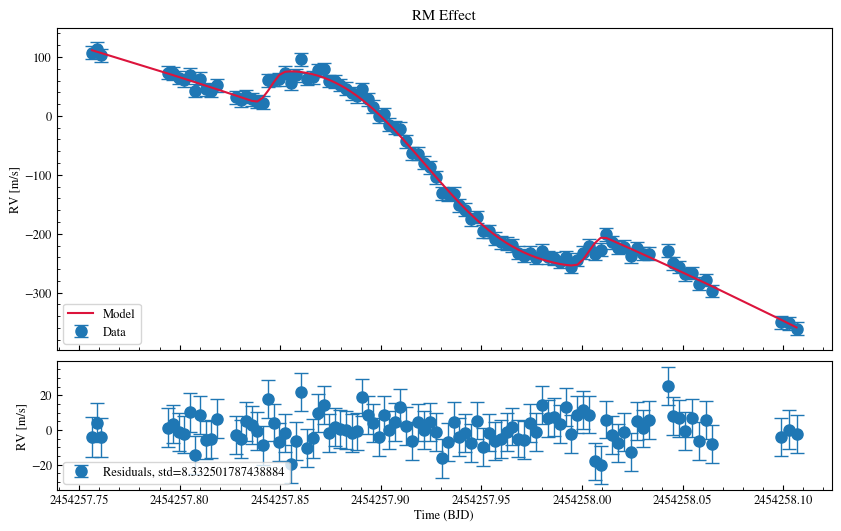

In [16]:
tabela.plot_fit(tabela.min_pv)

$\quad$ O comando `tabela.minimize_PyDE(mcmc=True, mc_iter=1000)` realiza a minimização da função de probabilidade utilizando o método PyDE, mas desta vez com o MCMC (Monte Carlo Markov Chain). A opção `mcmc=True` indica que, ao invés de uma otimização determinística, será feita uma amostragem estocástica dos parâmetros do modelo. O parâmetro `mc_iter=1000` especifica que o MCMC realizará 1000 iterações para explorar o espaço de parâmetros e gerar as distribuições posteriores dos parâmetros. Esse processo é usado para estimar as incertezas dos parâmetros e construir uma distribuição de probabilidade para cada um deles.

In [17]:
%%capture
tabela.minimize_PyDE(mcmc=True,mc_iter=1000)

$\quad$ Abaixo, geramos um gráfico que visualiza o ajuste do modelo após o processo de MCMC. Ele plota a curva do modelo correspondente aos valores médios dos parâmetros obtidos a partir das distribuições posteriores geradas pelo MCMC. Além disso, o gráfico inclui as barras de erro ou intervalos de confiança, destacando as incertezas associadas ao ajuste. Essa visualização ajuda a comparar como o modelo ajustado se comporta em relação aos dados observados, considerando as estimativas mais prováveis dos parâmetros e suas variações.

No flatchain passed, defaulting to using full chains
Plotting curve with best-fit mcmc values


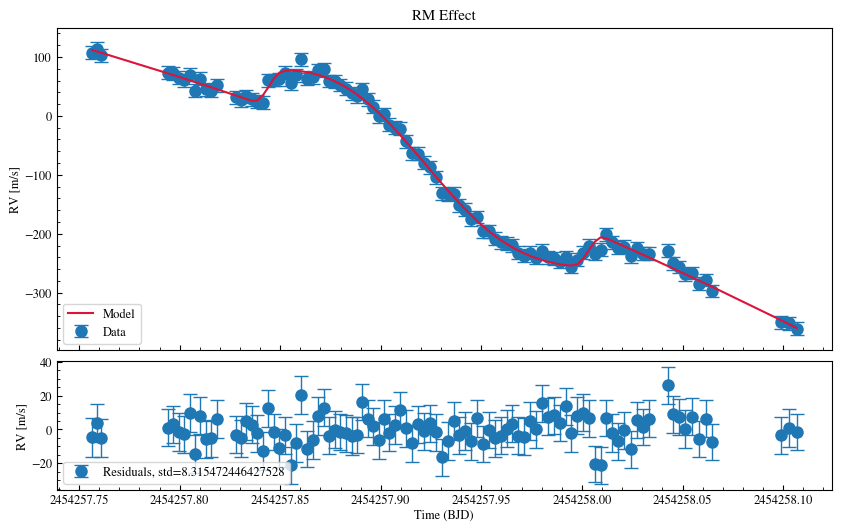

In [18]:
tabela.plot_mcmc_fit()

$\quad$ A variável `dados_coletados` faz um "achatamento" das amostras, reorganizando o array em uma matriz 2D onde cada linha representa uma amostra posterior de parâmetros, e o número de colunas corresponde ao número de parâmetros ajustáveis. Isso facilita a análise e visualização posterior.

In [19]:
descarte = 200 #Define o número de iterações iniciais do MCMC a serem descartadas
maior_probabilidade = tabela.sampler.chain[:,descarte:,:] # Seleciona as amostras de MCMC após o descarte das primeiras 200 iterações
dados_coletados = maior_probabilidade.reshape((-1,len(tabela.lpf.ps_vary.priors)))
df2 = pd.DataFrame(dados_coletados,columns=tabela.lpf.ps_vary.labels)

In [20]:
rmfit.mcmc_help.gelman_rubin(maior_probabilidade)

array([1.15178751, 1.17128891, 1.26614824, 1.28994859, 1.42358342,
       1.17115603, 1.37929639, 1.16178234, 1.13771427, 1.12395984,
       1.18109082, 1.16205587, 1.19465146, 1.19432479])

$\quad$ Abaixo criamos um gráfico visual detalhado que permite examinar as distribuições de probabilidade e as correlações entre os parâmetros ajustados após o MCMC, fornecendo insights importantes sobre a precisão e a interdependência dos parâmetros estimados.

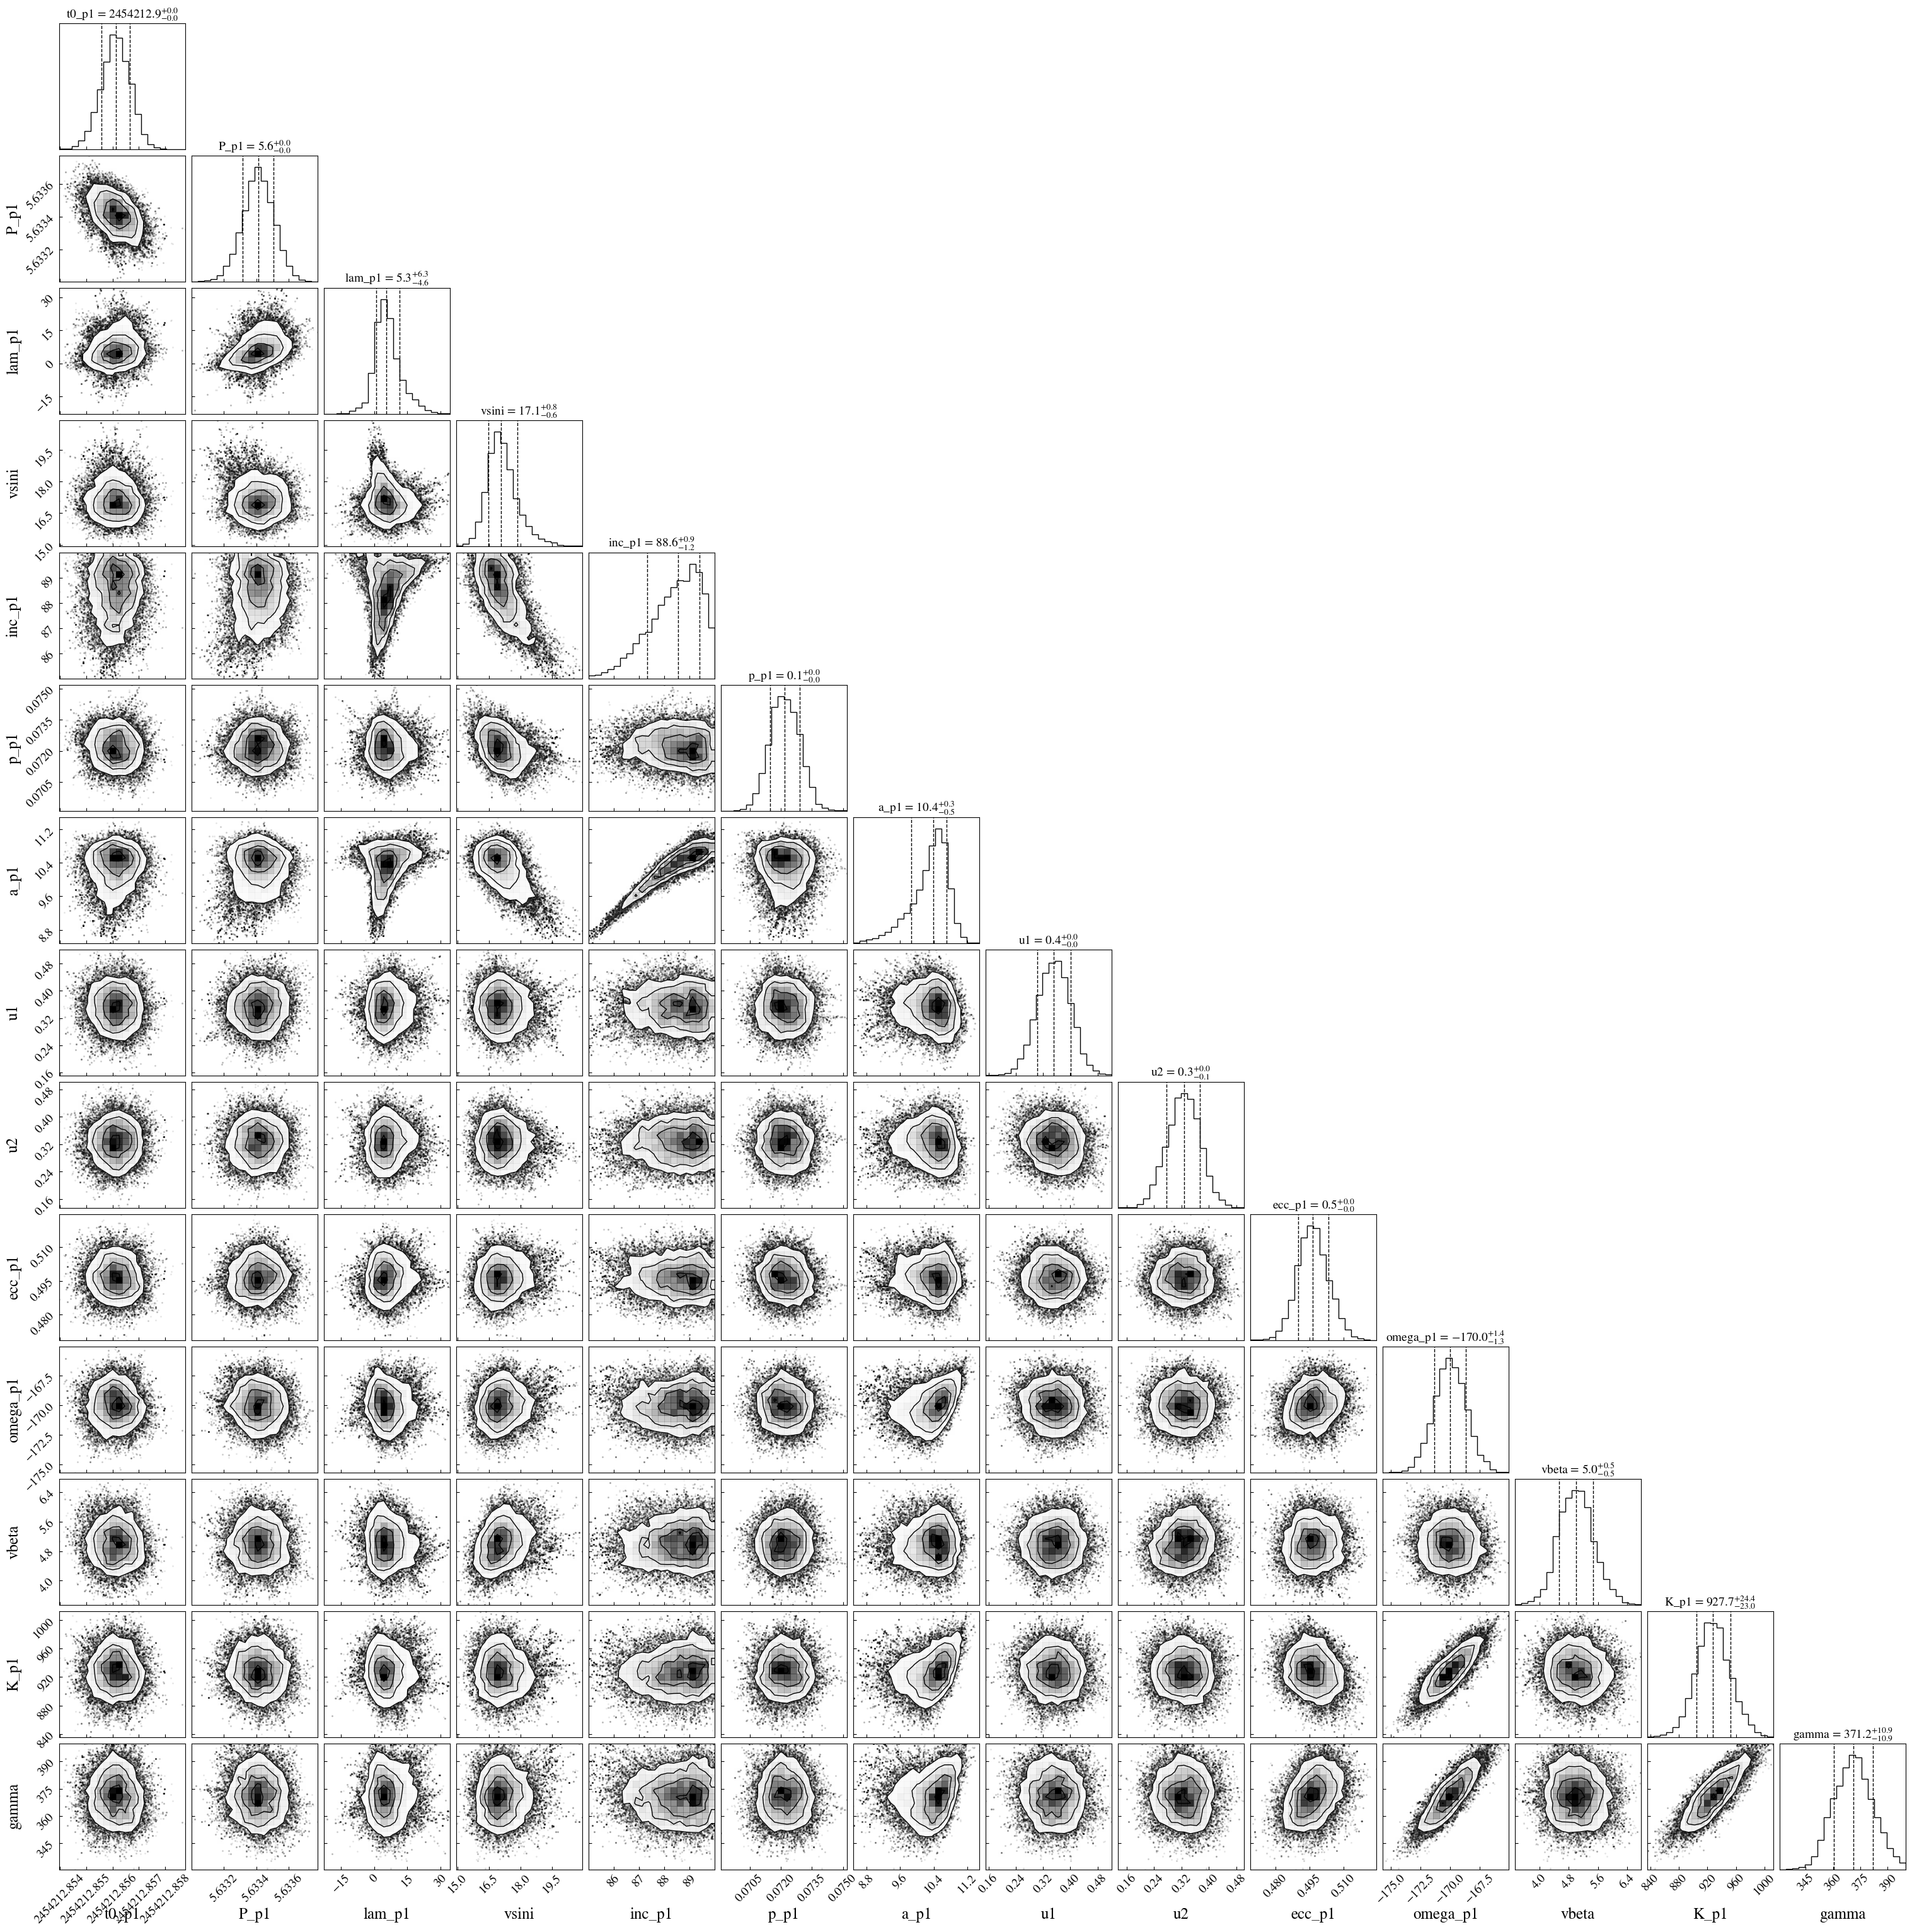

In [21]:
fig = rmfit.mcmc_help.plot_corner(maior_probabilidade,show_titles=True,labels=np.array(tabela.lpf.ps_vary.descriptions),title_fmt='.1f',xlabcord=(0.5, -0.2))

 $\quad$ Abaixo criamos uma visualização eficiente das distribuições posteriores para os parâmetros lam_p1 e vsini, incluindo intervalos de confiança e a mediana, para ajudar na interpretação das incertezas dos resultados do MCMC.

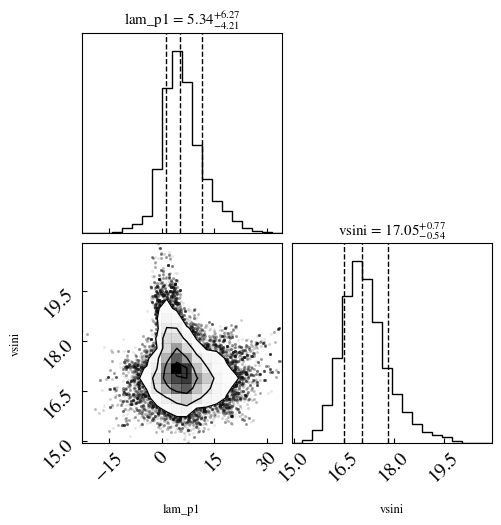

In [22]:
fig = corner.corner(df2[['lam_p1','vsini']],show_titles=True,quantiles=[0.18,0.5,0.84])
fig.dpi=100

$\quad$ O comando abaixo extrai os valores médios dos parâmetros ajustados após o MCMC, que representam as melhores estimativas desses parâmetros.

In [23]:
df_media = tabela.get_mean_values_mcmc_posteriors(df2.values)

In [24]:
df_media

medvals      minus       plus                                 values  \
0  2.454213e+06   0.000546   0.000542  $2454212.85612_{-0.00055}^{+0.00054}$   
0  5.633412e+00   0.000095   0.000096       $5.633412_{-0.00010}^{+0.00010}$   
0  5.337154e+00   4.574490   6.269871                    $5.3_{-4.6}^{+6.3}$   
0  1.705192e+01   0.581158   0.774558                $17.05_{-0.58}^{+0.77}$   
0  8.855126e+01   1.228149   0.859897                 $88.55_{-1.2}^{+0.86}$   
0  7.218099e-02   0.000688   0.000730        $0.07218_{-0.00069}^{+0.00073}$   
0  1.039096e+01   0.529030   0.311425                $10.39_{-0.53}^{+0.31}$   
0  3.521472e-01   0.049660   0.048293              $0.352_{-0.050}^{+0.048}$   
0  3.267418e-01   0.050007   0.046103              $0.327_{-0.050}^{+0.046}$   
0  4.962887e-01   0.006435   0.007074           $0.4963_{-0.0064}^{+0.0071}$   
0 -1.699958e+02   1.298084   1.363774                 $-170.0_{-1.3}^{+1.4}$   
0  4.999113e+00   0.458549   0.466866                  $5.0_{-0.46}^{+0.47}$   
0  9.276795e+02  23.014092  24.400062                $928.0_{-23.0}^{+24.0}$   
0  3.711883e+02  10.856232  10.891927                $371.0_{-11.0}^{+11.0}$   

     Labels Description  
0     t0_p1       t0_p1  
0      P_p1        P_p1  
0    lam_p1      lam_p1  
0     vsini       vsini  
0    inc_p1      inc_p1  
0      p_p1        p_p1  
0      a_p1        a_p1  
0        u1          u1  
0        u2          u2  
0    ecc_p1      ecc_p1  
0  omega_p1    omega_p1  
0     vbeta       vbeta  
0      K_p1        K_p1  
0     gamma       gamma

$\quad$ Por fim, criamos um gráfico que mostra os dados observacionais de velocidade radial (RV) com as incertezas e, ao mesmo tempo, exibe o modelo ajustado de RV (no caso, o modelo central a partir da mediana do MCMC). Onde temos o valor de lambda.

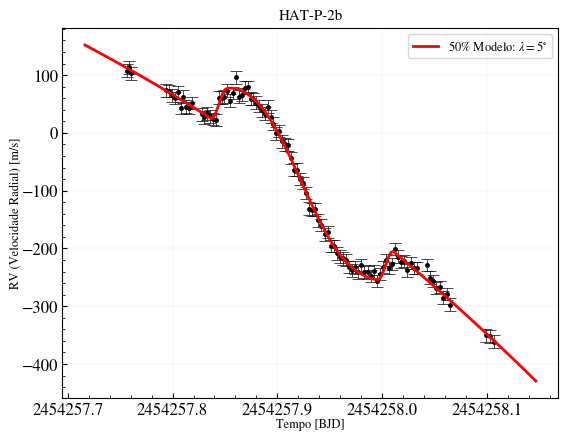

In [25]:
tempo = np.linspace(tabela.lpf.data['x'][0]-0.02,tabela.lpf.data['x'][-1]+0.02,500)
pv_50 = np.percentile(dados_coletados,[50],axis=0)[0]
t2 = np.linspace(tempo.min()-0.02,tempo.max()+0.02,300)
rv_50 = tabela.lpf.compute_total_model(pv_50,t2)

fig, ax = plt.subplots(dpi=100)

ax.errorbar(tabela.lpf.data['x'],tabela.lpf.data['y'],tabela.lpf.data['error'],
            marker='o',elinewidth=0.5,capsize=4,lw=0,mew=0.5,color="black",markersize=3)
ax.plot(t2,rv_50,color="red",
        label=r'50% Modelo: $\lambda=${:0.0f}'.format(pv_50[2])+'$^{\circ}$',lw=2.,zorder=10)

ax.legend(loc='upper right')
ax.set_xlabel('Tempo [BJD]',labelpad=0)
ax.set_ylabel('RV (Velocidade Radial) [m/s]',labelpad=0)
ax.set_title('HAT-P-2b')
rmfit.utils.ax_apply_settings(ax)

$\quad$ A partir da simulação do efeito Rossiter-McLaughlin (RM), utilizando o código desenvolvido, conseguimos ajustar os parâmetros do modelo para os dados observacionais da estrela HAT-P-2. O valor de $\lambda$, que representa a inclinação do plano orbital do exoplaneta em relação ao equador da estrela, foi estimado com base na forma das variações da velocidade radial observadas durante o trânsito do exoplaneta.

$\quad$ Esse valor de $\lambda = 6º$ sugere que o plano orbital do exoplaneta HAT-P-2 tem uma ligeira inclinação em relação ao equador da estrela. Essa inclinação baixa indica que a órbita do exoplaneta está quase alinhada com o equador da estrela, mas não perfeitamente. Isso significa que o trânsito do exoplaneta, ao ser observado da Terra, não ocorre exatamente no plano equatorial da estrela, mas com um pequeno ângulo de inclinação.

# Conclusão

$\quad$ Neste trabalho, abordamos a determinação da obliquidade estelar de um exoplaneta utilizando a técnica do efeito Rossiter-McLaughlin, que permite a modelagem da variação na velocidade radial observada durante o trânsito planetário. Esse efeito ocorre devido ao movimento do planeta sobre a superfície da estrela, influenciado pela rotação estelar.

$\quad$ Utilizamos dados reais de observações para realizar as simulações e obter uma estimativa precisa da obliquidade, que descreve o ângulo entre o eixo de rotação da estrela e o plano orbital do exoplaneta. Através de um processo de modelagem, simulações numéricas e o uso de métodos de inferência estatística, como o MCMC (Markov Chain Monte Carlo), conseguimos ajustar o modelo ao conjunto de dados observacionais, calculando as distribuições posteriores dos parâmetros do sistema estelar-planetário.

## Referências

**[1]** Storopoli, Jose. “Estatística Bayesiana Com R E Stan: Markov Chain Monte Carlo -- MCMC.” Estatística Bayesiana Com R E Stan, Aug. 2021, storopoli.io/Estatistica-Bayesiana/5-MCMC.html, https://doi.org/10.18637/jss.v076.i01;citation_issn=1548-7660;citation_author.

**[2]** Barbosa, Ruben. “Deteção de Exoplanetas: Efeito Rossiter-McLaughlin.” AstroPT - Informação E Educação Científica, 20 Apr. 2018, www.astropt.org/2018/04/20/detecao-de-exoplanetas-efeito-rossiter-mclaughlin/. Accessed 16 Nov. 2024.

**[3]** Winn, Joshua N. “The Rossiter-McLaughlin Effect for Exoplanets.” Proceedings of the International Astronomical Union, vol. 6, no. S276, Oct. 2010, pp. 230–237, https://doi.org/10.1017/s1743921311020230.

**[4]** Ohta, Yasuhiro, et al. “The Rossiter‐McLaughlin Effect and Analytic Radial Velocity Curves for Transiting Extrasolar Planetary Systems.” The Astrophysical Journal, vol. 622, no. 2, Apr. 2005, pp. 1118–1135, https://doi.org/10.1086/428344. Accessed 26 Mar. 2022.

**[5]** Cegla, H. M., et al. “The Rossiter-McLaughlin Effect Reloaded: Probing the 3D Spin-Orbit Geometry, Differential Stellar Rotation, and the Spatially-Resolved Stellar Spectrum of Star-Planet Systems.” Astronomy & Astrophysics, vol. 588, 30 Mar. 2016, p. A127, https://doi.org/10.1051/0004-6361/201527794. Accessed 17 Mar. 2022.

**[6]** Hirano, Teruyuki, et al. “IMPROVED MODELING of the ROSSITER-McLAUGHLIN EFFECT for TRANSITING EXOPLANETS.” The Astrophysical Journal, vol. 742, no. 2, 7 Nov. 2011, p. 69, https://doi.org/10.1088/0004-637x/742/2/69. Accessed 10 Mar. 2022.

**[7]** Guđmundur Stefànsson, et al. “The Warm Neptune GJ 3470b Has a Polar Orbit.” the Astrophysical Journal. Letters, vol. 931, no. 2, 26 May 2022, pp. L15–L15, https://doi.org/10.3847/2041-8213/ac6e3c. Accessed 23 May 2024.

**[8]** “OBLIQUITIES of HOT JUPITER HOST STARS: EVIDENCE for TIDAL INTERACTIONS and PRIMORDIAL MISALIGNMENTS.” The Astrophysical Journal, vol. 757, no. 1, 30 Aug. 2012, p. 18, https://doi.org/10.1088/0004-637x/757/1/18. Accessed 10 Feb. 2020.